In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## The Toast Myth

We saw the Mythbusters crew do an experiment with 48 pieces of toast, where 29 landed butter side up and 19 butter side down.  Let's see if we can figure out how likely this outcome would be, if toast was equally likely to land on either side.  In particular, we'll play a "what-if" game: what if toast was equally likely to land on both sides?  Let's simulate what would happen, under that assumption.

In [2]:
sides = make_array('Butter Side Up', 'Butter Side Down')

In [3]:
possible_outcomes = Table().with_column('Outcome', sides)

In [4]:
possible_outcomes

Outcome
Butter Side Up
Butter Side Down


In [5]:
simulated_experiment = possible_outcomes.sample(48)

In [6]:
simulated_experiment

Outcome
Butter Side Up
Butter Side Up
Butter Side Up
Butter Side Up
Butter Side Down
Butter Side Down
Butter Side Up
Butter Side Down
Butter Side Down
Butter Side Up


In [7]:
simulated_experiment.group('Outcome')

Outcome,count
Butter Side Down,22
Butter Side Up,26


In [8]:
def count_up(sample):
    counts = sample.group('Outcome').where('Outcome', 'Butter Side Up')
    number_up = counts.column('count').item(0)
    return number_up

In [9]:
count_up(simulated_experiment)

26

## Simulation

Above we saw how to simulate an episode of the TV show (i.e., one experiment), under the "what-if" assumption that toast is equally likely to land on both sides.  Now we're going to repeat the simulation 10000 times, and keep track of the statistic (the number of times the toast landed butter-side-up) we get from each simulated TV episode.

In [10]:
counts = make_array()
for i in np.arange(10000): # 10000 repetitions
    one_simulated_episode = possible_outcomes.sample(48)
    number_up = count_up(one_simulated_episode)
    counts = np.append(counts, number_up)
results = Table().with_column('Number that landed butter-side-up', counts)

In [11]:
results

Number that landed butter-side-up
23
24
27
27
23
20
28
31
24
31


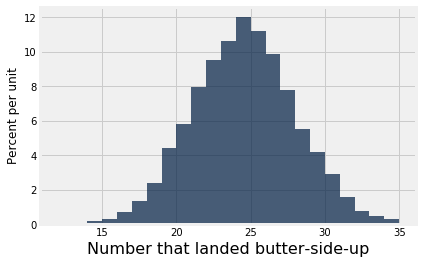

In [12]:
results.hist(bins=np.arange(12,36,1))

In [13]:
results.where('Number that landed butter-side-up',
              are.above_or_equal_to(29)).num_rows / 10000

0.1022

## Swain v. Alabama, repeat

In [14]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


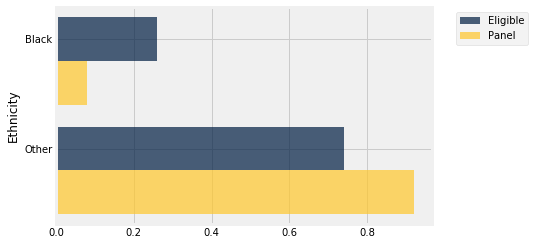

In [15]:
swain.barh(0)

## Total Variation Distance

In [16]:
diff = swain.with_column('Difference', swain.column(1) - swain.column(2))
diff

Ethnicity,Eligible,Panel,Difference
Black,26%,8%,0.18
Other,74%,92%,-0.18


In [17]:
abs_diff = diff.with_column('Abs. Difference', np.abs(diff.column(3)))
abs_diff

Ethnicity,Eligible,Panel,Difference,Abs. Difference
Black,26%,8%,0.18,0.18
Other,74%,92%,-0.18,0.18


In [18]:
sum(abs_diff.column('Abs. Difference')) / 2

0.18000000000000002

In [19]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

In [20]:
def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

In [21]:
table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

## Simulating the statistic, for Swain v. Alabama

In [22]:
def get_one_simulated_panel(t, n):
    return t.select('Ethnicity').sample(n, weights=t.column('Eligible'))

In [23]:
get_one_simulated_panel(swain, 100)

Ethnicity
Black
Other
Other
Other
Other
Other
Other
Other
Other
Other


In [24]:
def simulate_once(t, panel_size):
    simulated_panel = get_one_simulated_panel(t, panel_size)
    counts = simulated_panel.group('Ethnicity')
    sim_proportions = counts.select('Ethnicity').with_column('Random',
                                    counts.column('count') / panel_size)
    sim_proportions.set_format(1, PercentFormatter(0))
    return swain.join('Ethnicity', sim_proportions)

In [25]:
simulate_once(swain, 100)

Ethnicity,Eligible,Panel,Random
Black,26%,8%,31%
Other,74%,92%,69%


In [26]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(10000): # 10000 repetitions of the simulation
    sim_results = simulate_once(swain, 100)
    tvds = np.append(tvds, table_tvd(sim_results, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.05
0.02
0.05
0.02
0.05
0.07
0.02
0
0.02
0.01


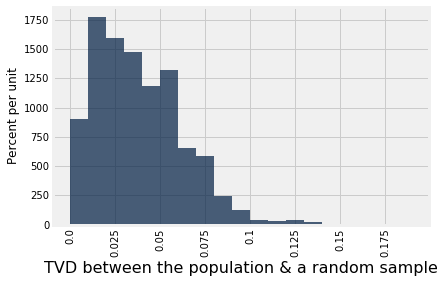

In [27]:
results.hist(bins=np.arange(0, 0.20, 0.010))

## Alameda County Juries

In [28]:
# Data from an ACLU 2010 report
# Racial and Ethnic Disparities in Alameda County Jury Pools
# https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf

alameda = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

alameda.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


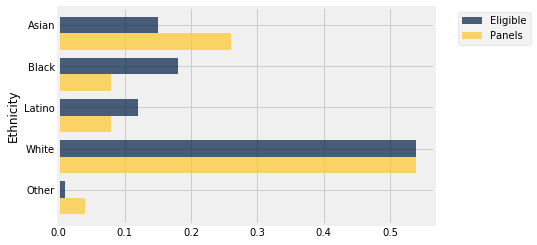

In [29]:
alameda.barh(0)

In [30]:
table_tvd(alameda, 'Eligible', 'Panels')

0.14000000000000001

In [31]:
simulate_once(alameda)

TypeError: simulate_once() missing 1 required positional argument: 'panel_size'

In [ ]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # 1000 repetitions of the simulation
    sim_results = simulate_once(alameda, 1453)
    tvds = np.append(tvds, table_tvd(sim_results, 'Eligible', 'Random'))

results = Table().with_column('TVD', tvds)
results

In [ ]:
results.hist(bins=np.arange(0, 0.2, 0.01))

## Alameda juries, analyzed differently

In [ ]:
Table().with_columns('side', ['heads', 'tails']).sample(1000, weights=[.8, .2]).group(0)

In [ ]:
def sample_from_distribution(t, category_label, distribution_label, sample_size):
    categories = t.select(category_label)
    distribution = t.column(distribution_label)
    return categories.sample(sample_size, weights=distribution)

sample_from_distribution(alameda, 'Ethnicity', 'Eligible', 10)

In [ ]:
def with_random_sample(t, category_label, distribution_label, sample_size):
    """Return t with a column that contains category proportions of a random sample."""
    sample = sample_from_distribution(t, category_label, distribution_label, sample_size)
    counts = sample.group(0)
    sample_proportions = counts.select(0).with_column('Random', counts.column(1) / sample_size)
    sample_proportions.set_format(1, PercentFormatter(0))
    return t.join(category_label, sample_proportions)

with_random_sample(alameda, 'Ethnicity', 'Eligible', 1453)

### Repeated trials

In [ ]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = with_random_sample(alameda, 'Ethnicity', 'Eligible', 1453)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

In [ ]:
results.hist(bins=np.arange(0, 0.2, 0.01))

Discussion question: How do you think our analysis would change if the jury panels had only 50 people?

In [ ]:
with_random_sample(panels, 'Ethnicity', 'Eligible', 50)

In [ ]:
tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = with_random_sample(panels, 'Ethnicity', 'Eligible', 50)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results.hist(bins=np.arange(0, 0.2, 0.01))

## Addendum: Alameda County Race & Ethnicity Distribution

In [ ]:
# According to the 2010 Census, https://www.census.gov/2010census/popmap/

alameda_race = Table(['Race', 'Population']).with_rows([
    ['White', 649122],
    ['African American', 190451],
    ['Asian', 394560],
    ['AIAN', 9799],
    ['NHPI', 12802],
    ['Some Other Race', 162540],
    ['Two or more Races', 90997],
])

alameda_race.set_format(1, DistributionFormatter).show()

alameda_ethnicity = Table(['Ethnicity', 'Population']).with_rows([
    ['Hispanic or Latino', 339889],
    ['Not Hispanic or Latino', 1170382],
])

alameda_ethnicity.set_format(1, DistributionFormatter).show()

In [ ]:
panels

## Chi-Squared (Optional)

In [ ]:
def chi_squared(dist, other, sample_size):
    return sum((dist - other) ** 2 / dist) * sample_size

def table_xs(t, label, other, sample_size):
    return chi_squared(t.column(label), t.column(other), sample_size)

observed = table_xs(panels, 'Eligible', 'Panels', 1453)
observed

In [ ]:
table_xs(panels, 'Panels', 'Eligible', 1453)

In [ ]:
xs = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = with_random_sample(panels, 'Ethnicity', 'Eligible', 1453)
    xs = np.append(xs, table_xs(new_sample, 'Eligible', 'Random', 1453))

results = Table().with_column('Chi-Squared between the population & a random sample', xs)
results.hist()

## P-Value

In [ ]:
results.where(0, are.above_or_equal_to(observed)).num_rows / results.num_rows